# ARDL模型预测水泥产业电碳关系

- 采用ARDL模型探究水泥产业碳排放与电力消耗以及其他生产要素之间的关系

- 采用数据集：中国碳核算数据库（China Emission Accounts and Datasets, CEADs，https://www.ceads.net.cn/data/ ）
- 数据为1996-2016年全国各省（除港澳台）水泥产业相关数据共651组

## 导入所需库

In [1]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as pdates
import warnings
warnings.filterwarnings("ignore")

## 加载数据并显示结尾5行

In [2]:
data=pd.read_csv(".//data//cement.csv")
data.tail()

,Year,Location,cement_production,clinker_production,clinker_to_cement_ratios,coal_consumption,electricity_consumption,process_related_CO2,coal_related_CO2,electricity_related_CO2,total_CO2
646,2016,Shaanxi,7264.04,3513.842090,0.528480,664.444628,614.093181,1744.271214,331.557869,614.093181,2689.922264
647,2016,Gansu,4640.40,2864.119824,0.674311,594.878749,473.494240,1421.749081,296.844496,473.494240,2192.087817
648,2016,Qinghai,1895.42,1054.029499,0.607536,228.078910,93.135392,523.220244,113.811376,93.135392,730.167011
649,2016,Ningxia,1984.71,1286.484021,0.708161,235.931200,224.485707,638.610668,117.729669,224.485707,980.826044
650,2016,Xinjiang,4250.23,2761.406555,0.709810,607.732267,481.549450,1370.762214,303.258401,481.549450,2155.570066


## 输入要考察的省份

In [3]:
Provinces=data.Location.drop_duplicates()

province=input("请输入省份(默认为北京)：" )or "Beijing"
while province not in Provinces.values:
    province=input("输入错误，请重新输入(默认为北京)：" )or "Beijing"

请输入省份(默认为北京)：


## 查看各项数据的分布

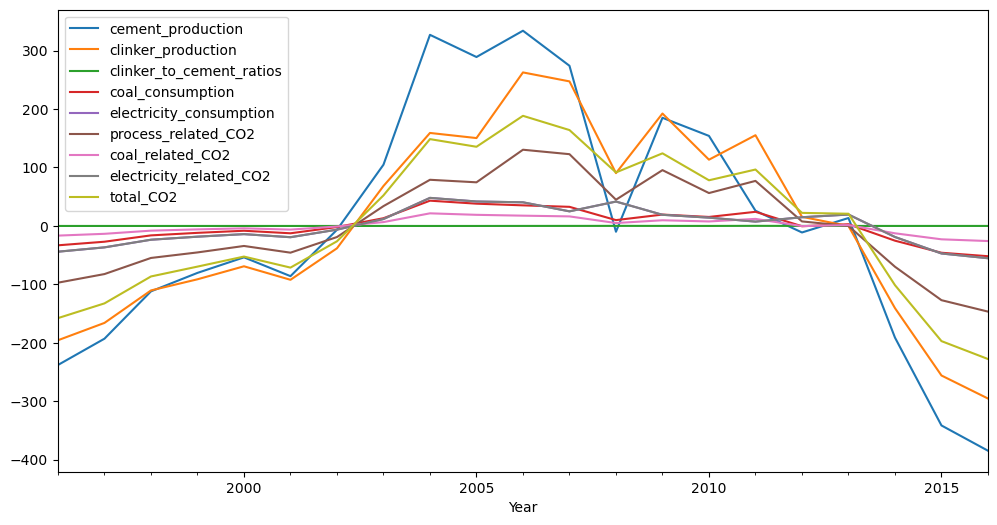

In [4]:
data=data[data.Location==province]
data.index=data.Year
data.index=pd.to_datetime(data.index,format="%Y")
data=data.drop(columns=['Year','Location'])
ax=(data-data.mean()).plot(figsize=(12,6))

## 划分生成所需的训练集和验证集

In [5]:
test_num=5
train_set=data[0:-test_num]
test_set=data[-test_num:]
test_set.tail()

,cement_production,clinker_production,clinker_to_cement_ratios,coal_consumption,electricity_consumption,process_related_CO2,coal_related_CO2,electricity_related_CO2,total_CO2
Year,,,,,,,,,
2012-01-01,883.757116,632.213089,0.729657,121.390008,165.987052,313.830577,60.573614,165.987052,540.391243
2013-01-01,908.489191,616.450629,0.687962,124.787126,170.632224,306.006092,62.268776,170.632224,538.907092
2014-01-01,703.860000,475.981051,0.687962,96.679924,132.198818,236.276994,48.243282,132.198818,416.719094
2015-01-01,553.500000,360.703665,0.687962,76.026963,103.958238,179.053299,37.937455,103.958238,320.948992
2016-01-01,510.280000,321.328040,0.687962,70.090404,95.840668,159.507239,34.975112,95.840668,290.323019


## 获取训练集上的最优ARDL阶数

In [13]:
sel_res=ardl_select_order(train_set.total_CO2,2,
                          train_set[["cement_production","clinker_production","coal_consumption","electricity_consumption"]],
                          1,ic='aic',trend='c')
print(f"最优ARDL阶数为:{sel_res.model.ardl_order}")

最优ARDL阶数为:(2, 1, 1, 1, 1)


- 此处尝试了不同的最大回归阶数设置，发现水泥碳排放最好的回归阶数都是0，
- 也就是说，水泥产业碳排放与排放量历史数据无关，与外生变量的历史数据也无关
- 只是外生变量当前值的回归
- 原因分析见后

ARDL回归的结果概览

In [14]:
res=sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARDL Model Results                              
===============================================================================
Dep. Variable:               total_CO2   No. Observations:                   16
Model:             ARDL(2, 1, 1, 1, 1)   Log Likelihood                 114.710
Method:                Conditional MLE   S.D. of innovations              0.000
Date:                 Fri, 14 Apr 2023   AIC                           -205.419
Time:                         15:08:10   BIC                           -197.751
Sample:                     01-01-1998   HQIC                          -206.129
                          - 01-01-2011                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1.248e-07      0.000      0.000      1.000      -0.001       0.001
total_CO2.L1                  -0.4347   1299.679     -0.000      1.000   -4136.593    4135.723
total_CO2.L2                -1.45e-09   2.42e-06     -0.001      1.000    -7.7e-06    7.69e-06
cement_production.L0       -4.258e-10   1.22e-06     -0.000      1.000   -3.89e-06    3.89e-06
cement_production.L1       -4.225e-09   8.03e-06     -0.001      1.000   -2.56e-05    2.56e-05
clinker_production.L0          0.4964   2.59e-06   1.92e+05      0.000       0.496       0.496
clinker_production.L1          0.2158    645.161      0.000      1.000   -2052.973    2053.405
coal_consumption.L0            0.4990   1.13e-05   4.43e+04      0.000       0.499       0.499
coal_consumption.L1            0.2169    648.540      0.000      1.000   -2063.726    2064.160
electricity_consumption.L0     1.0000   1.22e-05   8.22e+04      0.000       1.000       1.000
electricity_consumption.L1     0.4347   1299.679      0.000      1.000   -4135.723    4136.593
==============================================================================================
"""

结果的检测

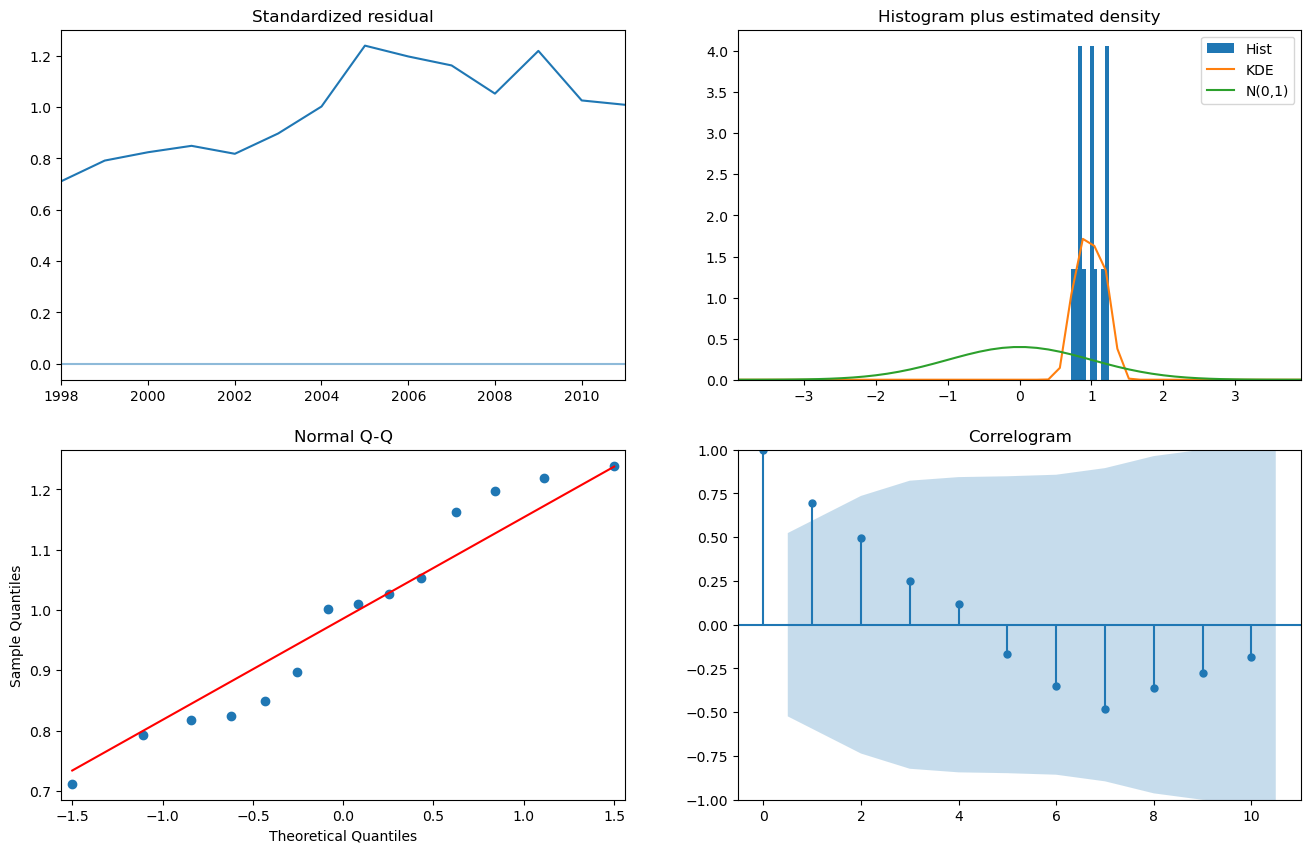

In [15]:
res.plot_diagnostics(figsize=(16,10))
plt.show()

## 用训练的模型进行预测

In [16]:
predict2=res.get_prediction(start=len(data)-test_num,end=len(data)-1,exog_oos=test_set[['cement_production',
                                                                                        'clinker_production',
                                                                                        'coal_consumption',
                                                                                        'electricity_consumption']])
predict_value=pd.Series(predict2.predicted_mean.values,index=test_set.index)
predict_conf_int=predict2.conf_int()
predict_conf_int.index=test_set.index

## 预测误差

In [17]:
err=np.mean(np.abs(predict_value-test_set.total_CO2)/test_set.total_CO2)*100
print("平均误差为%.3f"% err,"%")

平均误差为0.000 %


## 预测结果图

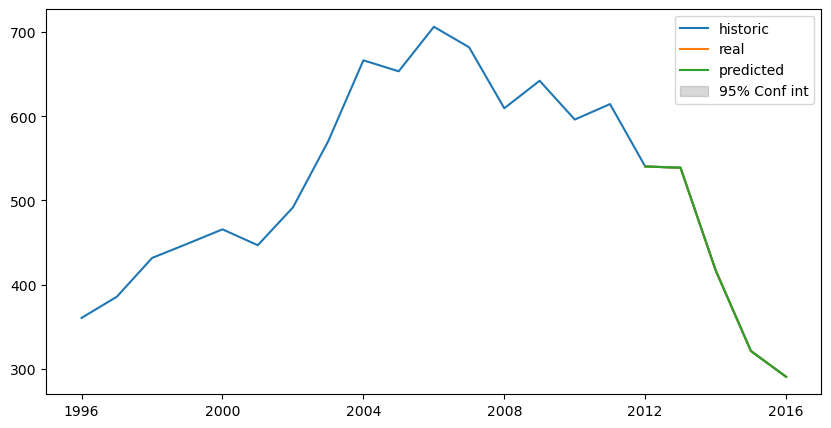

In [18]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(data.index,data.total_CO2,label='historic')
ax.plot(test_set.index,test_set.total_CO2,label='real')
ax.plot(predict_value.index,predict_value.values,label='predicted')
ax.fill_between(predict_conf_int.index,predict_conf_int['lower'],predict_conf_int['upper'],alpha=0.3,color='grey',label="95% Conf int")
ax.legend(loc='best')
plt.show()

In [14]:
%%time
for province in Provinces:
#     data=data[data.Location==province]
#     data.index=data.Year
#     data.index=pd.to_datetime(data.index,format="%Y")
#     data=data.drop(columns=['Year','Location'])
    
    test_num=4
    train_set=data[0:-test_num]
    test_set=data[-test_num:]
    
    sel_res=ardl_select_order(train_set.total_CO2,0,train_set[["cement_production","clinker_production","coal_consumption","electricity_consumption"]],0,ic='aic',trend='c')
    print(f"{province}的最优ARDL阶数为:{sel_res.model.ardl_order}")
    
    res=sel_res.model.fit()
    predict2=res.get_prediction(start=len(data)-test_num,end=len(data)-1,exog_oos=test_set[['cement_production','clinker_production','coal_consumption','electricity_consumption']])
    predict_value=pd.Series(predict2.predicted_mean.values,index=test_set.index)
    err=np.mean(np.abs(predict_value-test_set.total_CO2)/test_set.total_CO2)*100
    print(province,"的三项回归分别为",list(res.params.index),"，系数分别为:",res.params.values)
    print(province,"的平均预测误差为%.3f"% err,"%\n")

Beijing的最优ARDL阶数为:(0, 0, 0, 0, 0)
Beijing 的三项回归分别为 ['const', 'cement_production.L0', 'clinker_production.L0', 'coal_consumption.L0', 'electricity_consumption.L0'] ，系数分别为: [-3.27021610e-09  1.58668079e-10  4.96400000e-01  4.99000005e-01
  9.99999995e-01]
Beijing 的平均预测误差为0.000 %

Tianjin的最优ARDL阶数为:(0, 0, 0, 0, 0)
Tianjin 的三项回归分别为 ['const', 'cement_production.L0', 'clinker_production.L0', 'coal_consumption.L0', 'electricity_consumption.L0'] ，系数分别为: [-3.27021610e-09  1.58668079e-10  4.96400000e-01  4.99000005e-01
  9.99999995e-01]
Tianjin 的平均预测误差为0.000 %

Hebei的最优ARDL阶数为:(0, 0, 0, 0, 0)
Hebei 的三项回归分别为 ['const', 'cement_production.L0', 'clinker_production.L0', 'coal_consumption.L0', 'electricity_consumption.L0'] ，系数分别为: [-3.27021610e-09  1.58668079e-10  4.96400000e-01  4.99000005e-01
  9.99999995e-01]
Hebei 的平均预测误差为0.000 %

Shanxi的最优ARDL阶数为:(0, 0, 0, 0, 0)
Shanxi 的三项回归分别为 ['const', 'cement_production.L0', 'clinker_production.L0', 'coal_consumption.L0', 'electricity_consumption.L0'] ，系数分别为: 

对31个省的数据分别进行了计算，发现各省水泥产业碳排放公式如下：
$$E_{\text{CO}_2}=k_1\times P_\text{cement}+k_2\times C_\text{coal}+k_3\times W_\text{elec}$$
其中$E_{\text{CO}_2}$为二氧化碳排放，$P_\text{cement}$为水泥产量，$C_\text{coal}$为煤炭消耗量，$W_\text{elec}$为耗电量。耗电量单位为10kWh，其余单位为万吨。

怀疑数据集的碳排放并非采集数据，而是用排放因子计算出的数据。

In [15]:
data

,cement_production,clinker_production,clinker_to_cement_ratios,coal_consumption,electricity_consumption,process_related_CO2,coal_related_CO2,electricity_related_CO2,total_CO2
Year,,,,,,,,,
1996-01-01,438.000000,146.725210,0.342797,12.564398,32.615638,72.834394,6.269635,32.615638,111.719667
1997-01-01,339.000000,113.825824,0.342797,9.736339,25.274342,56.503139,4.858433,25.274342,86.635914
1998-01-01,339.000000,114.834424,0.342797,9.743889,25.293941,57.003808,4.862200,25.293941,87.159949
1999-01-01,254.761053,85.917643,0.342797,7.313783,18.985684,42.649518,3.649578,18.985684,65.284779
2000-01-01,317.032994,107.924874,0.342797,9.101511,23.626406,53.573907,4.541654,23.626406,81.741968
2001-01-01,433.690066,147.028048,0.342797,12.450549,32.320099,72.984723,6.212824,32.320099,111.517646
2002-01-01,353.313043,120.291849,0.342797,10.143053,26.330122,59.712874,5.061383,26.330122,91.104380
2003-01-01,745.213247,267.003598,0.360597,21.393882,55.535895,132.540586,10.675547,55.535895,198.752028
2004-01-01,977.166564,324.401729,0.333027,28.052891,72.821866,161.033018,13.998393,72.821866,247.853277


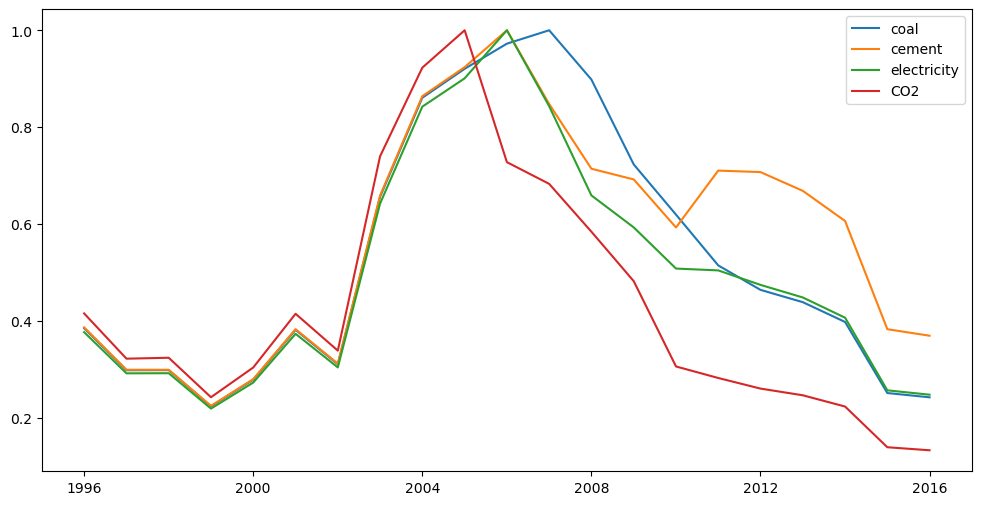

In [16]:
fig,ax=plt.subplots(figsize=(12,6))
# ax.plot(data.index,data.electricity_consumption,label='electricity')
# ax.plot(data.index,data.coal_consumption,label='coal')
ax.plot(data.index,data.coal_consumption/data.coal_consumption.max(),label='coal')
ax.plot(data.index,data.cement_production/data.cement_production.max(),label='cement')
ax.plot(data.index,data.electricity_consumption/data.electricity_consumption.max(),label='electricity')
ax.plot(data.index,data.total_CO2/data.total_CO2.max(),label='CO2')
plt.legend(loc='best')
plt.show()

In [21]:
from statsmodels.api import OLS
import statsmodels.api as sm

In [37]:
x=data.electricity_consumption
y=data.cement_production
x=sm.add_constant(x)
model=OLS(y,x)
model2=OLS(y,data.electricity_consumption)
res_cement2elec=model.fit()
res_cement2elec2=model2.fit()
print("R^2=",res_cement2elec.rsquared)
# print("回归方程为：y=%.2f"% res_cement2elec.params[0],"+%.2f"% res_cement2elec.params[1],"x")
# print(res_cement2elec.params)
res_cement2elec2.summary()

R^2= 0.8834105647081815


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      cement_production   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              925.3
Date:                Mon, 10 Apr 2023   Prob (F-statistic):                    3.20e-18
Time:                        14:51:14   Log-Likelihood:                         -126.70
No. Observations:                  21   AIC:                                      255.4
Df Residuals:                      20   BIC:                                      256.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
electricity_consumption    14.4579      0.475     30.419      0.000      13.466      15.449
==============================================================================
Omnibus:                        2.910   Durbin-Watson:                   0.177
Prob(Omnibus):                  0.233   Jarque-Bera (JB):                2.248
Skew:                           0.671   Prob(JB):                        0.325
Kurtosis:                       2.123   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

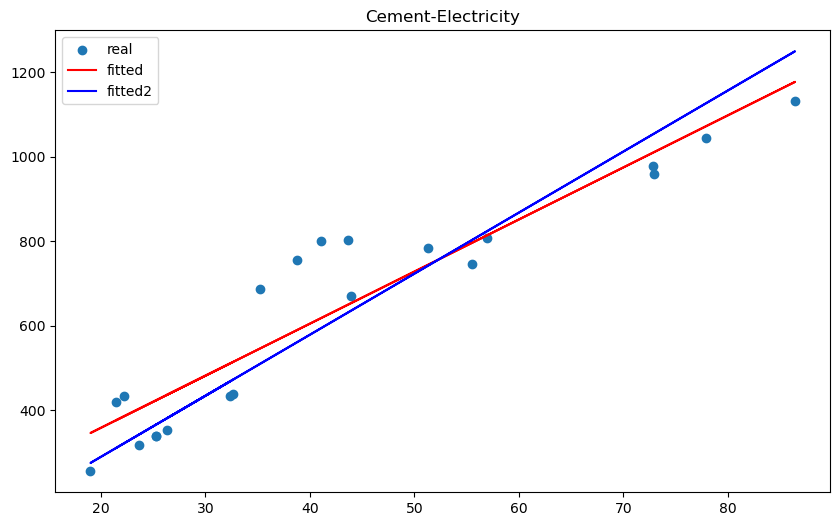

In [31]:
fig,ax=plt.subplots(figsize=(10,6))
ax.scatter(data.electricity_consumption,data.cement_production,label='real')
ax.plot(data.electricity_consumption,res_cement2elec.fittedvalues,color='red',label='fitted')
ax.plot(data.electricity_consumption,res_cement2elec2.fittedvalues,color='blue',label='fitted2')
ax.legend(loc='best')
plt.title("Cement-Electricity")
plt.show()

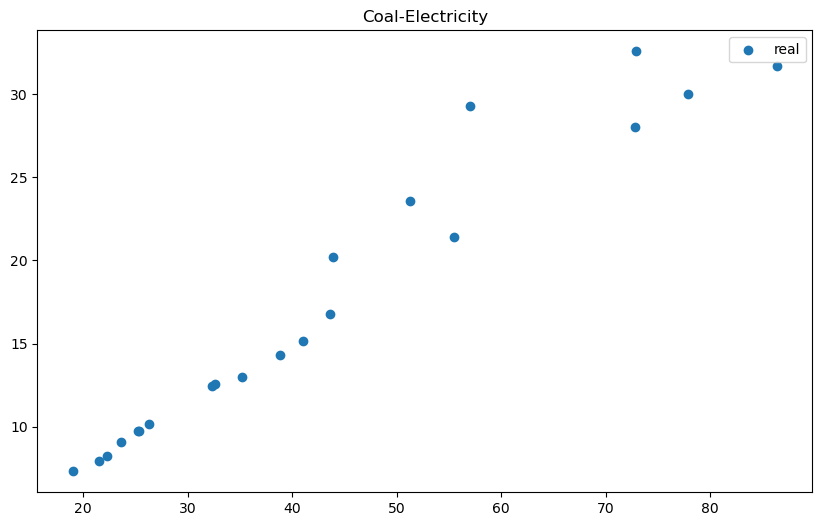

In [34]:
fig,ax=plt.subplots(figsize=(10,6))
ax.scatter(data.electricity_consumption,data.coal_consumption,label='real')
# ax.plot(data.electricity_consumption,res_cement2elec.fittedvalues,color='red',label='fitted')
# ax.plot(data.electricity_consumption,res_cement2elec2.fittedvalues,color='blue',label='fitted2')
ax.legend(loc='best')
plt.title('Coal-Electricity')
plt.show()